In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
def reshape_df(df):
    #idは意味を持たないため削除
    df.drop('id',axis=1,inplace=True)

    #print(train_df["StandardHours"].value_counts())
    #80    1200
    #Name: StandardHours, dtype: int64
    df.drop('StandardHours',axis=1,inplace=True)

    #print(train_df["Over18"].value_counts())
    #Y    1200
    #Name: Over18, dtype: int64
    df.drop('Over18',axis=1,inplace=True)

    #https://deepage.net/features/pandas-replace.html
    df=df.replace({
        #BusinessTravel
        'Non-Travel':0,
        'Travel_Rarely':1,
        'Travel_Frequently':2,
        #Gender
        'Male':0,
        'Female':1,
        #OverTime
        'No':0,
        'Yes':1,
    })

    #https://note.nkmk.me/python-pandas-get-dummies/
    df=pd.get_dummies(df, columns=["Department", "EducationField","JobRole","MaritalStatus"],sparse=True)
    return df

import scipy.stats
import torch
from torch.utils.data import DataLoader, TensorDataset

def preprocess(x_df,y_df):
    #https://note.nkmk.me/python-list-ndarray-dataframe-normalize-standardize/
    x=scipy.stats.zscore(x_df.values,ddof=1)
    x=torch.from_numpy(x).float()
    y=torch.from_numpy(y_df.values).long()
    return (x,y)

from sklearn.model_selection import train_test_split
def do_all_preprocess(primary_df,ans_df):
    #
    primary_df=reshape_df(primary_df)
    width=len(primary_df.iloc[0,:])
    height=len(primary_df.iloc[:,0])
    #
    train_x,test_x,train_y,test_y = train_test_split(primary_df,ans_df,test_size = 0.1)
    #
    train_x,train_y=preprocess(primary_df,ans_df)
    test_x,test_y=preprocess(test_x,test_y)
    #
    train_dataset=TensorDataset(train_x,train_y)
    train_loader=DataLoader(train_dataset, shuffle=True)
    test_dataset=TensorDataset(test_x,test_y)
    test_loader=DataLoader(test_dataset, shuffle=True)
    return train_loader,test_loader#,width,height

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#https://techtech-sorae.com/pytorch%E3%82%92%E7%94%A8%E3%81%84%E3%81%A6%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0%E3%81%AB%E3%82%88%E3%82%8B%E3%83%AF%E3%82%A4%E3%83%B3%E5%88%86%E9%A1%9E/
# ネットワークのモジュール化
class Net(nn.Module):
    def __init__(self, input):
        super(Net, self).__init__()
        
        # ネットワークを定義
        self.fc1 = nn.Linear(input, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.softmax=nn.Softmax()

    # 順伝搬を定義
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu( self.fc2(x))
        x = self.relu( self.fc3(x))
        x = self.relu( self.fc4(x))
        x = self.relu( self.fc5(x))
        x = self.fc6(x)
        x=self.softmax(x)
        return x

from numpy.ma.core import count
from datetime import datetime
from pytz import timezone
import matplotlib.pyplot as plt

def train_process(Net,train_loader,test_loader):
    model = Net(47)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion=nn.NLLLoss()

    epoch_num=250
    loss_list=[]*epoch_num

    model.train()
    for i in range(epoch_num):
        total_loss = 0
        for x,y in train_loader:
            optimizer.zero_grad()
            pred_y = model(x)
            loss = criterion(pred_y, y)
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()
        if i%50==0:
            print("epoch "+str(i)+" "+datetime.now(timezone('Asia/Tokyo')).strftime('%m/%d %H:%M:%S')+" total_loss:"+str(total_loss))
            loss_list.append(total_loss)
    plt.plot(loss_list)
    plt.show()
    #
    model.eval()
    pred_y_list=[]
    y_list=[]
    with torch.no_grad(): 
        for x,y in test_loader:
            pred_y = model(x)
            y_list.append(y.item())
            pred_y_list.append(torch.argmax(pred_y).item())
    
    return model,y_list,pred_y_list

In [3]:
import pandas as pd
import copy

primary_df=pd.read_csv('/content/drive/MyDrive/signate/従業員の離職予測/train.csv')
ans_df=primary_df.loc[:,'Attrition']
primary_df.drop('Attrition',axis=1,inplace=True)

FileNotFoundError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 07/26 16:04:53 total_loss:-876.2639864031225
epoch 50 07/26 16:06:11 total_loss:-986.9846600986574
epoch 100 07/26 16:07:27 total_loss:-986.9936552182736
epoch 150 07/26 16:08:42 total_loss:-986.9961598145575
epoch 200 07/26 16:09:56 total_loss:-986.9972908388752
epoch 250 07/26 16:11:11 total_loss:-986.9979195037095
epoch 300 07/26 16:12:25 total_loss:-986.9983184246216
epoch 350 07/26 16:13:39 total_loss:-986.9985928765813
epoch 400 07/26 16:14:52 total_loss:-986.9987886472536
epoch 450 07/26 16:16:06 total_loss:-986.9989379148642


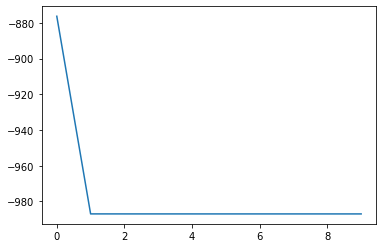

In [ ]:
train_loader,test_loader=do_all_preprocess(primary_df,ans_df)
model,true_y,pred_y=train_process(Net,train_loader,test_loader)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
print((np.array(pred_y[:])==np.array(true_y[:])).sum()/len(true_y))
print(confusion_matrix(true_y,pred_y, labels=[1, 0]))

0.8416666666666667
[[  0  19]
 [  0 101]]
